In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel

In [2]:
print(os.listdir("J:/IMAGE+CLASSIFICATION"))

['training', 'tt', 'validate', 'vv']


In [3]:
SIZE = 128

#Capture images and labels into arrays.
#Start by creating empty lists.
train_images = []
train_labels = [] 
for directory_path in glob.glob("J:/IMAGE+CLASSIFICATION/training/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = []
test_labels = [] 
for directory_path in glob.glob("J:/IMAGE+CLASSIFICATION/validate/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

defected
J:/IMAGE+CLASSIFICATION/training\defected\1.jpg
J:/IMAGE+CLASSIFICATION/training\defected\10.jpg
J:/IMAGE+CLASSIFICATION/training\defected\100.jpg
J:/IMAGE+CLASSIFICATION/training\defected\101.jpg
J:/IMAGE+CLASSIFICATION/training\defected\102.jpg
J:/IMAGE+CLASSIFICATION/training\defected\103.jpg
J:/IMAGE+CLASSIFICATION/training\defected\104.jpg
J:/IMAGE+CLASSIFICATION/training\defected\105.jpg
J:/IMAGE+CLASSIFICATION/training\defected\106.jpg
J:/IMAGE+CLASSIFICATION/training\defected\107.jpg
J:/IMAGE+CLASSIFICATION/training\defected\108.jpg
J:/IMAGE+CLASSIFICATION/training\defected\109.jpg
J:/IMAGE+CLASSIFICATION/training\defected\11.jpg
J:/IMAGE+CLASSIFICATION/training\defected\110.jpg
J:/IMAGE+CLASSIFICATION/training\defected\111.jpg
J:/IMAGE+CLASSIFICATION/training\defected\112.jpg
J:/IMAGE+CLASSIFICATION/training\defected\113.jpg
J:/IMAGE+CLASSIFICATION/training\defected\114.jpg
J:/IMAGE+CLASSIFICATION/training\defected\115.jpg
J:/IMAGE+CLASSIFICATION/training\defected\116

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
#If you only have one dataset then split here
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
def feature_extractor(dataset):
    number = 0;
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        number = number+1; 
        print(number)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        input_img = x_train[image, :,:,:]
        img = input_img
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
    #Add feature extractors, e.g. edge detection, smoothing, etc. 
            
         # FEATURE 1 - Pixel values
         
        #Add pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        #df['Image_Name'] = image   #Capture image name as we read multiple images
        
        # FEATURE 2 - Bunch of Gabor filter responses
        
                #Generate Gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
         
        # FEATURE 3 Sobel
#        edge_sobel = sobel(img)
#        edge_sobel1 = edge_sobel.reshape(-1)
#        df['Sobel'] = edge_sobel1
       
        #Add more filters as needed
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset
print("start")
number = 0;
image_features = feature_extractor(x_train)
print("stop");
#Reshape to a vector for Random Forest / SVM training
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features

#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

#Predict on test
test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

start
1
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
2
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
3
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
4
Gabor1 : theta= 0.0 : sigma= 1 :

<AxesSubplot:>

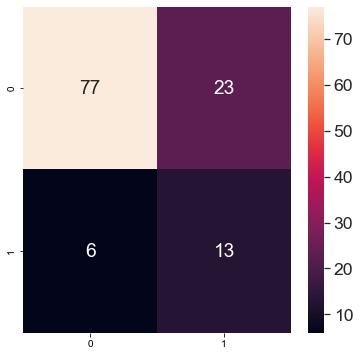

In [8]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_prediction)
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

1
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5


C:\Users\hp\ANNACONDA\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The prediction for this image is:  ['defected']
The actual label for this image is:  defected


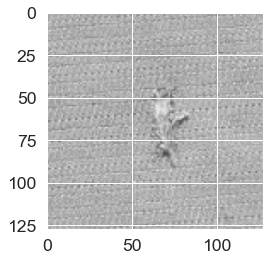

In [9]:
import random
n=random.randint(0, x_test.shape[0]-1) #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

#Extract features and reshape to right dimensions
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))
#Predict
img_prediction = RF_model.predict(input_img_for_RF)
img_prediction = le.inverse_transform([img_prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])